In [ ]:
import argparse 
import os
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import torchvision.transforms as transforms
from torchvision import datasets
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
cuda = True if torch.cuda.is_available() else False
device = 'cuda:0' if cuda else 'cpu'

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

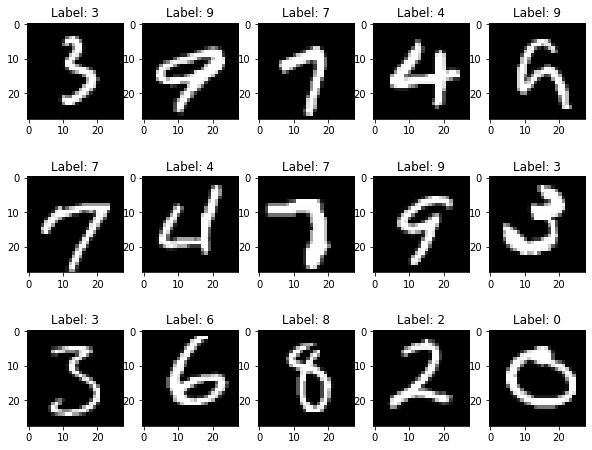

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor(),                           
  transforms.Normalize(mean=(0.5,), std=(0.5,))   
])

mnist_train  = datasets.MNIST(root='data', download=True, train=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)


fig,axes = plt.subplots(3,5,figsize=(10,8))

examples = enumerate(train_loader)
_, (ex_data, ex_targets) = next(examples)

for i in range(15):
    ax = axes[i//5,i%5]
    ax.imshow(ex_data[i][0],cmap='gray')
    ax.set_title('Label: {}'.format(ex_targets[i]))

plt.show()

# function and module

In [ ]:
class cGAN_Generator(nn.Module):
    def __init__(self, n_classes=10):
        super(cGAN_Generator, self).__init__()

        self.label_emb = nn.Embedding(10, n_classes)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, z, labels):
        z = z.view(z.size(0), -1)
        c = self.label_emb(labels).view(z.size(0),-1)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), img_size, img_size)

class cGAN_Discriminator(nn.Module):
    def __init__(self,n_classes=10):
        super(cGAN_Discriminator, self).__init__()

        self.label_emb = nn.Embedding(10, n_classes)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x, labels):
        x = x.view(x.size(0), -1)
        c = self.label_emb(labels.long())
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

def cGAN_train_discriminator(cGAN_discriminator, cGAN_generator, images, labels):
    cGAN_d_optimizer.zero_grad()        
    real_images = images.to(device)                                              
    real_labels = labels.to(device)                                             
    real_labels_output = torch.ones(images.size(0)).to(device)               

    real_validity = cGAN_discriminator(real_images, real_labels)                
    real_loss = cGAN_criterion(real_validity, real_labels_output).to(device)     

    z = torch.randn(images.size(0), latent_dim).to(device)                       
    fake_labels = torch.LongTensor(np.random.randint(0, n_classes, images.size(0))).to(device) 
    fake_images = cGAN_generator(z, fake_labels)                                 
    fake_labels_output = torch.zeros(images.size(0)).to(device)                
    fake_validity = cGAN_discriminator(fake_images, fake_labels)               
    fake_loss = cGAN_criterion(fake_validity, fake_labels_output).to(device)    
    d_loss = real_loss + fake_loss                                              
    d_loss.backward()                                                          
    cGAN_d_optimizer.step()                                                  
    
    return d_loss.item()

def cGAN_train_generator(cGAN_discriminator, cGAN_generator, batch_size):
    cGAN_g_optimizer.zero_grad()

    real_labels_output = torch.ones(batch_size).to(device)                      

    z = torch.randn(batch_size, latent_dim).to(device)                         
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device) 
    fake_images = cGAN_generator(z, fake_labels)                              
    

    fake_validity = cGAN_discriminator(fake_images, fake_labels)                 
    g_loss = cGAN_criterion(fake_validity, real_labels_output)                                                                       

    g_loss.backward()                                                          
    cGAN_g_optimizer.step()                                                    

    return g_loss.item()

def test_plot_cGAN(num_test_samples,plot_axis,generator,latent_dim):
    (a,b) = plot_axis
    test_noise = torch.randn(num_test_samples, latent_dim).to(device)
    test_labels = torch.LongTensor([i for i in range(n_classes)]).to(device)
    fig,axes = plt.subplots(b,a,figsize=(2*a,2.5*b))

    test_images = generator(test_noise,test_labels)

    for i in range(num_test_samples):
        ax = axes[i//a,i%a]
        ax.imshow(test_images[i,:].data.cpu().numpy().reshape(img_size, img_size),cmap='gray')

    plt.show()

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [ ]:
cGAN_lr = 0.0002                                                             

cGAN_criterion = torch.nn.BCELoss()

cGAN_generator = cGAN_Generator()
cGAN_discriminator = cGAN_Discriminator()
cGAN_generator.weight_init(mean=0.0,std=0.02)
cGAN_discriminator.weight_init(mean=0.0,std=0.02)

if cuda:
    cGAN_generator.cuda()
    cGAN_discriminator.cuda()
    cGAN_criterion.cuda()

cGAN_g_optimizer = torch.optim.Adam(cGAN_generator.parameters(), lr=cGAN_lr)
cGAN_d_optimizer = torch.optim.Adam(cGAN_discriminator.parameters(), lr=cGAN_lr)

In [ ]:
cGAN_D_losses = []
cGAN_G_losses = []
total_losses = []
n_epochs = 500                                                                   
 
for epoch in tqdm(range(n_epochs)):
    cGAN_d_avg_loss = 0
    cGAN_g_avg_loss = 0

    for n, (images, labels) in enumerate(train_loader):
        d_loss = cGAN_train_discriminator(cGAN_discriminator, cGAN_generator, images, labels)      
        g_loss = cGAN_train_generator(cGAN_discriminator, cGAN_generator, batch_size)         

        cGAN_d_avg_loss += d_loss
        cGAN_g_avg_loss += g_loss

    cGAN_d_avg_loss /= len(train_loader)
    cGAN_g_avg_loss /= len(train_loader)
    cGAN_D_losses.append(cGAN_d_avg_loss)
    cGAN_G_losses.append(cGAN_g_avg_loss)
    total_losses.append(cGAN_d_avg_loss + cGAN_g_avg_loss)

    if epoch % 100 == 0 :
      print('Epoch : [{}] d_loss : {:4f} g_loss : {:4f} total_loss : {:4f}'.format(epoch, cGAN_d_avg_loss, cGAN_g_avg_loss, cGAN_d_avg_loss + cGAN_g_avg_loss))




  0%|          | 0/500 [00:00<?, ?it/s]


  0%|          | 1/500 [00:13<1:49:30, 13.17s/it]

Epoch : [0] d_loss : 1.047470 g_loss : 1.708381 total_loss : 2.755851





  0%|          | 2/500 [00:26<1:49:09, 13.15s/it]


  1%|          | 3/500 [00:39<1:48:38, 13.11s/it]


  1%|          | 4/500 [00:52<1:48:57, 13.18s/it]


  1%|          | 5/500 [01:05<1:48:28, 13.15s/it]


  1%|          | 6/500 [01:18<1:48:13, 13.15s/it]


  1%|▏         | 7/500 [01:31<1:47:44, 13.11s/it]


  2%|▏         | 8/500 [01:45<1:47:56, 13.16s/it]


  2%|▏         | 9/500 [01:58<1:48:07, 13.21s/it]


  2%|▏         | 10/500 [02:11<1:47:48, 13.20s/it]


  2%|▏         | 11/500 [02:24<1:47:16, 13.16s/it]


  2%|▏         | 12/500 [02:37<1:46:36, 13.11s/it]


  3%|▎         | 13/500 [02:50<1:46:25, 13.11s/it]


  3%|▎         | 14/500 [03:03<1:46:15, 13.12s/it]


  3%|▎         | 15/500 [03:16<1:45:41, 13.07s/it]


  3%|▎         | 16/500 [03:30<1:45:40, 13.10s/it]


  3%|▎         | 17/500 [03:43<1:45:28, 13.10s/it]


  4%|▎         | 18/500 [03:56<1:45:17, 13.11s/it]


  4%|▍         | 19/500 [04:09<1:45:14, 13.13s/it]


  4%|▍         | 20/500 [04:22<1:44:59, 13.12s/it]


Epoch : [100] d_loss : 1.274442 g_loss : 0.888636 total_loss : 2.163078





 20%|██        | 102/500 [22:25<1:27:20, 13.17s/it]


 21%|██        | 103/500 [22:38<1:27:05, 13.16s/it]


 21%|██        | 104/500 [22:51<1:27:00, 13.18s/it]


 21%|██        | 105/500 [23:04<1:26:36, 13.15s/it]


 21%|██        | 106/500 [23:17<1:26:24, 13.16s/it]


 21%|██▏       | 107/500 [23:30<1:25:58, 13.13s/it]


 22%|██▏       | 108/500 [23:43<1:25:36, 13.10s/it]


 22%|██▏       | 109/500 [23:57<1:25:31, 13.13s/it]


 22%|██▏       | 110/500 [24:10<1:25:02, 13.08s/it]


 22%|██▏       | 111/500 [24:23<1:24:49, 13.08s/it]


 22%|██▏       | 112/500 [24:36<1:24:30, 13.07s/it]


 23%|██▎       | 113/500 [24:49<1:24:40, 13.13s/it]


 23%|██▎       | 114/500 [25:02<1:24:45, 13.17s/it]


 23%|██▎       | 115/500 [25:15<1:24:23, 13.15s/it]


 23%|██▎       | 116/500 [25:28<1:23:42, 13.08s/it]


 23%|██▎       | 117/500 [25:41<1:23:28, 13.08s/it]


 24%|██▎       | 118/500 [25:54<1:23:11, 13.07s/it]


 24%|██▍       | 119/500 [26:08<1:23:10, 13.10s/it]


 24%|██▍       | 120/500 

Epoch : [200] d_loss : 1.317348 g_loss : 0.823578 total_loss : 2.140926





 40%|████      | 202/500 [44:16<1:05:12, 13.13s/it]


 41%|████      | 203/500 [44:29<1:04:57, 13.12s/it]


 41%|████      | 204/500 [44:42<1:04:36, 13.10s/it]


 41%|████      | 205/500 [44:55<1:04:21, 13.09s/it]


 41%|████      | 206/500 [45:09<1:04:23, 13.14s/it]


 41%|████▏     | 207/500 [45:22<1:04:07, 13.13s/it]


 42%|████▏     | 208/500 [45:35<1:03:37, 13.07s/it]


 42%|████▏     | 209/500 [45:48<1:03:11, 13.03s/it]


 42%|████▏     | 210/500 [46:01<1:03:05, 13.05s/it]


 42%|████▏     | 211/500 [46:14<1:02:40, 13.01s/it]


 42%|████▏     | 212/500 [46:27<1:02:36, 13.04s/it]


 43%|████▎     | 213/500 [46:40<1:02:29, 13.06s/it]


 43%|████▎     | 214/500 [46:53<1:02:24, 13.09s/it]


 43%|████▎     | 215/500 [47:06<1:02:14, 13.10s/it]


 43%|████▎     | 216/500 [47:19<1:01:53, 13.08s/it]


 43%|████▎     | 217/500 [47:32<1:01:33, 13.05s/it]


 44%|████▎     | 218/500 [47:45<1:01:26, 13.07s/it]


 44%|████▍     | 219/500 [47:58<1:01:17, 13.09s/it]


 44%|████▍     | 220/500 

Epoch : [300] d_loss : 1.329120 g_loss : 0.802560 total_loss : 2.131680





 60%|██████    | 302/500 [1:06:19<44:15, 13.41s/it]


 61%|██████    | 303/500 [1:06:32<44:01, 13.41s/it]


 61%|██████    | 304/500 [1:06:45<43:47, 13.41s/it]


 61%|██████    | 305/500 [1:06:59<43:34, 13.41s/it]


 61%|██████    | 306/500 [1:07:12<43:23, 13.42s/it]


 61%|██████▏   | 307/500 [1:07:26<43:06, 13.40s/it]


 62%|██████▏   | 308/500 [1:07:39<42:48, 13.38s/it]


 62%|██████▏   | 309/500 [1:07:52<42:34, 13.38s/it]


 62%|██████▏   | 310/500 [1:08:06<42:24, 13.39s/it]


 62%|██████▏   | 311/500 [1:08:19<42:09, 13.38s/it]


 62%|██████▏   | 312/500 [1:08:32<41:59, 13.40s/it]


 63%|██████▎   | 313/500 [1:08:46<41:44, 13.39s/it]


 63%|██████▎   | 314/500 [1:08:59<41:31, 13.39s/it]


 63%|██████▎   | 315/500 [1:09:13<41:18, 13.40s/it]


 63%|██████▎   | 316/500 [1:09:26<40:59, 13.37s/it]


 63%|██████▎   | 317/500 [1:09:40<41:00, 13.44s/it]


 64%|██████▎   | 318/500 [1:09:53<40:44, 13.43s/it]


 64%|██████▍   | 319/500 [1:10:06<40:26, 13.41s/it]


 64%|██████▍   | 320/500 

Epoch : [400] d_loss : 1.334438 g_loss : 0.790072 total_loss : 2.124510





 80%|████████  | 402/500 [1:28:28<21:32, 13.19s/it]


 81%|████████  | 403/500 [1:28:41<21:16, 13.16s/it]


 81%|████████  | 404/500 [1:28:55<21:04, 13.17s/it]


 81%|████████  | 405/500 [1:29:08<20:48, 13.14s/it]


 81%|████████  | 406/500 [1:29:21<20:30, 13.09s/it]


 81%|████████▏ | 407/500 [1:29:34<20:21, 13.13s/it]


 82%|████████▏ | 408/500 [1:29:47<20:15, 13.21s/it]


 82%|████████▏ | 409/500 [1:30:01<20:09, 13.29s/it]


 82%|████████▏ | 410/500 [1:30:14<19:49, 13.21s/it]


 82%|████████▏ | 411/500 [1:30:27<19:34, 13.20s/it]


 82%|████████▏ | 412/500 [1:30:40<19:17, 13.15s/it]


 83%|████████▎ | 413/500 [1:30:53<19:06, 13.18s/it]


 83%|████████▎ | 414/500 [1:31:07<18:55, 13.20s/it]


 83%|████████▎ | 415/500 [1:31:20<18:40, 13.18s/it]


 83%|████████▎ | 416/500 [1:31:33<18:25, 13.16s/it]


 83%|████████▎ | 417/500 [1:31:46<18:11, 13.15s/it]


 84%|████████▎ | 418/500 [1:31:59<17:56, 13.12s/it]


 84%|████████▍ | 419/500 [1:32:12<17:43, 13.13s/it]


 84%|████████▍ | 420/500 

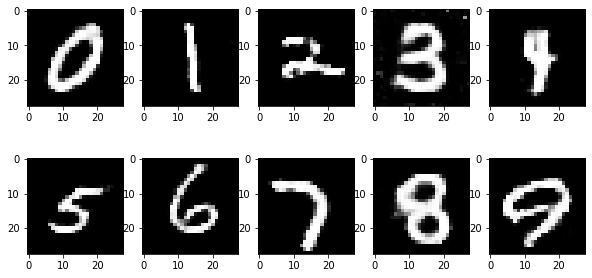

In [ ]:
n_classes = 10                                     
latent_dim = 100 
test_plot_cGAN(num_test_samples=n_classes,plot_axis=(5,2),generator=cGAN_generator,latent_dim=latent_dim)

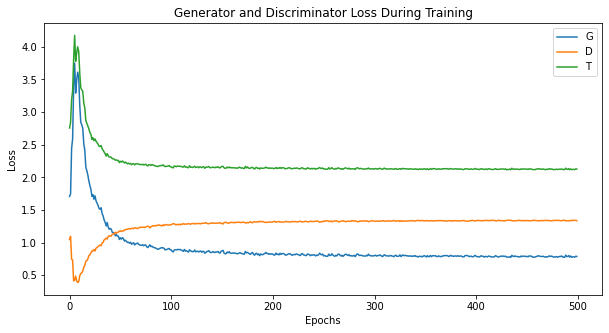

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(cGAN_G_losses,label="G")
plt.plot(cGAN_D_losses,label="D")
plt.plot(total_losses,label="T")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()